# Use Phonopy with qeAPI
Phonon/dispersion calculation could be time-consuming and hard to crack for a new comer. The following code is a standard work flow for using [phonopy](https://phonopy.github.io/phonopy/) with our qeAPI.

## First Steps

We need to install `phonopy` first. You can do it through anaconda or using source code. 
- For anaconda users, just open the anaconda prompt and type `conda install -c conda-forge phonopy` 
- For those who want to compile phonopy from source code,
    - first make sure that *Visual C++ 14.0* is installed using [Visual C++ Build tool](http://go.microsoft.com/fwlink/?LinkId=691126&fixForIE=.exe.)
    - Run the following commands in a python visual environment(`.venv`) command prompt:
        - `git clone https://github.com/phonopy/phonopy.git`
        - `cd phonopy`
        - `git checkout master`
        - `python setup.py build`
        - `pip install -e .`
    - If you're lucky, nothing abnormal would happen and you are good to use `phonopy`. However, `phonopy` installation depends on `numpy`, but it may fail sanity check while `pip` builds wheel. A workaround could be degrading `numpy ` using a command of `pip install numpy==1.19.3`. This method cannot guarantee the installation will succeed, so using anaconda is currently the best way.

In [1]:
import numpy as np
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from ase.io import read

## Prepare supercells with atomic displacements
The workflow starts from a cif file of a ground-state configuration, which could be an unit cell or a supercell.

In [2]:
file = 'C://Users//liu_s//Documents//BW_results//SA//Naf1//GS//Naf1gs.cif'
preatoms = read(file)

In [3]:
syms = preatoms.get_chemical_symbols()
cell = np.array(preatoms.get_cell())
spos = preatoms.get_scaled_positions()

In [4]:
import os
tag = os.path.split(file)[-1][:-4]

The following code generates supercells with displacements which have the same size as the original configuration. (see the third command below) You can also choose to generate larger supercells. A rule of thumb is that **supercells should have lattice constant ~10 Angstrom**

In [5]:
from phonopy.units import PwscfToTHz
unitcell = PhonopyAtoms(symbols=syms,cell=(cell),scaled_positions=spos)
phonon = Phonopy(unitcell,[[1, 0, 0], [0, 1, 0], [0, 0, 1]],factor=PwscfToTHz)
phonon.generate_displacements(distance=0.03)
supercells = phonon.supercells_with_displacements

## Prepare input file for SCF calculations using Quantum ESPRESSO

In [6]:
from ase import Atoms
import sys,glob
sys.path.insert(1, 'C://Users//liu_s//Desktop//CODE//qeAPI')
from raw2qe import *
from qe2cif import *
svpath = 'C://Users//liu_s//Documents//BW_ipts//SA//Naf1//Phonon//' 

for i,scell in enumerate(supercells):
    atoms = Atoms(symbols=scell.get_chemical_symbols(),scaled_positions=scell.get_scaled_positions(),
                  cell=scell.get_cell(),pbc=True)
    test = qeIpt(atoms=atoms,svpath=svpath,prefix=tag+'id{}'.format(i))
    test.update_default({'CONTROL':{'calculation':'scf'}})
    test.update_default({'SYSTEM':{'ibrav':14,'lda_plus_u':'.TRUE.','hubbard_u': [('Ni',3.0),('Fe',1.0)],
                                   'nspin':2,'starting_magnetization':[('Ni',0.5),('Fe',0.5)]}})
    test.update_default({'SYSTEM':{'ecutwfc':55,'ecutrho':55*9}})
    test.update_default({'ELECTRONS':{'conv_thr':1e-10}})
    test.update_default({'K_POINTS':{'x':4,'y':4,'z':4}})
    test.prep_pwipt()

## Get forces from each SCF calculation

In [9]:
import re,glob,sys
sys.path.insert(1, 'C://Users//liu_s//Desktop//CODE//qeAPI')
from qe2cif import *
respath = 'C://Users//liu_s//Documents//BW_results//SA//Naf1//Phonon//*_scf.out' 
files = glob.glob(respath)
files = sorted(files, key=lambda f: [int(n) for n in re.findall(r"\d+", f)])
set_of_forces = []
for f in files:
    cell = read_espresso_out(f,index=-1)
    forces = cell.get_forces()
    drift_force = forces.sum(axis=0)
    print(("[Phonopy] Drift force:" + "%11.5f" * 3) % tuple(drift_force))
    # Simple translational invariance
    for force in forces:
        force -= drift_force / forces.shape[0]
    set_of_forces.append(forces)

[Phonopy] Drift force:   -0.00000   -0.00000   -0.00000
[Phonopy] Drift force:   -0.00000   -0.00000    0.00000
[Phonopy] Drift force:   -0.00000   -0.00000    0.00000
[Phonopy] Drift force:   -0.00000    0.00000   -0.00000
[Phonopy] Drift force:   -0.00000    0.00000   -0.00000
[Phonopy] Drift force:   -0.00000    0.00000   -0.00000
[Phonopy] Drift force:   -0.00000    0.00000    0.00000
[Phonopy] Drift force:    0.00000    0.00000   -0.00000
[Phonopy] Drift force:    0.00000   -0.00000   -0.00000
[Phonopy] Drift force:   -0.00000   -0.00000   -0.00000
[Phonopy] Drift force:    0.00000    0.00000   -0.00000
[Phonopy] Drift force:    0.00000    0.00000    0.00000
[Phonopy] Drift force:    0.00000   -0.00000   -0.00000
[Phonopy] Drift force:    0.00000   -0.00000   -0.00000
[Phonopy] Drift force:    0.00000    0.00000   -0.00000
[Phonopy] Drift force:   -0.00000    0.00000    0.00000
[Phonopy] Drift force:   -0.00000   -0.00000   -0.00000
[Phonopy] Drift force:    0.00000   -0.00000   -

## Calculate DOS/Dispersion Relations

In [10]:
phonon.produce_force_constants(forces=set_of_forces)
print('')
print("[Phonopy] Phonon frequencies at Gamma:")
for i, freq in enumerate(phonon.get_frequencies((0, 0, 0))):
    print("[Phonopy] %3d: %10.5f THz" %  (i + 1, freq)) # THz

# DOS
phonon.set_mesh([21, 21, 21])
phonon.set_total_DOS(tetrahedron_method=True)
omegados = []
for omega, dos in np.array(phonon.get_total_DOS()).T:
    omegados.append([omega, dos])


[Phonopy] Phonon frequencies at Gamma:
[Phonopy]   1:   -0.10868 THz
[Phonopy]   2:   -0.06918 THz
[Phonopy]   3:   -0.04924 THz
[Phonopy]   4:    6.67963 THz
[Phonopy]   5:    9.04856 THz
[Phonopy]   6:   15.36626 THz
[Phonopy]   7:   18.79894 THz
[Phonopy]   8:   20.06193 THz
[Phonopy]   9:   24.70905 THz
[Phonopy]  10:   25.28452 THz
[Phonopy]  11:   30.24240 THz
[Phonopy]  12:   31.13604 THz
[Phonopy]  13:   34.20419 THz
[Phonopy]  14:   40.82365 THz
[Phonopy]  15:   41.88905 THz
[Phonopy]  16:   43.45973 THz
[Phonopy]  17:   43.96304 THz
[Phonopy]  18:   45.74953 THz
[Phonopy]  19:   45.99805 THz
[Phonopy]  20:   47.96009 THz
[Phonopy]  21:   50.50487 THz
[Phonopy]  22:   53.41767 THz
[Phonopy]  23:   53.78784 THz
[Phonopy]  24:   55.19374 THz
[Phonopy]  25:   56.58010 THz
[Phonopy]  26:   57.49527 THz
[Phonopy]  27:   60.69958 THz
[Phonopy]  28:   69.64178 THz
[Phonopy]  29:   72.43094 THz
[Phonopy]  30:   74.08291 THz
[Phonopy]  31:   89.31354 THz
[Phonopy]  32:   90.02199 THz


The negative frequencies at gamma point shown above indicate that **the harmonic approximation fails in a configuration subspace in vicinity of the calculated configuration**. To avoid this, we need to run relax/SCF calculation at higher cutoff energy level.

## Calculation Band structure by following highly symmetric path

In [33]:
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [10, 8]
path = [[[0, 0, 0], [0.5, 0, 0.5], [0.625, 0.25, 0.625]],
        [[0.375, 0.375, 0.75], [0, 0, 0], [0.5, 0.5, 0.5], [0.5, 0.25, 0.75]]]
labels = ["$\\Gamma$", "X", "U", "K", "$\\Gamma$", "L", "W"]
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
phonon.run_band_structure(qpoints, path_connections=connections, labels=labels)

## Plot dispersion relation (spaghetti plot)

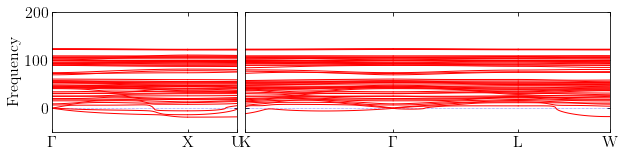

In [45]:
if phonon._band_structure.labels:
    from matplotlib import rc
    rc('text', usetex=True)

    if phonon._band_structure.is_legacy_plot:
        fig, axs = plt.subplots(1, 1)
    else:
        from mpl_toolkits.axes_grid1 import ImageGrid
        n = len([x for x in phonon._band_structure.path_connections
                 if not x])
        fig = plt.figure()
        axs = ImageGrid(fig, 111,  # similar to subplot(111)
                        nrows_ncols=(1, n),
                        axes_pad=0.11,
                        label_mode="L")
        axs.axes_llc.set_ylim(-50,200)
    phonon._band_structure.plot(axs)

## Plot DOS

Text(0, 0.5, 'DOS')

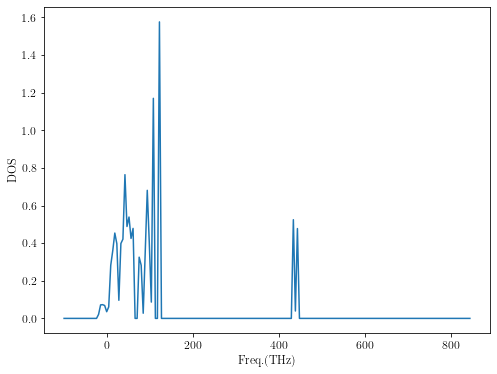

In [17]:
omegados = np.array(omegados)
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(omegados[:,0],omegados[:,1])
plt.xlabel('Freq.(THz)')
plt.ylabel('DOS')

## Plot thermodynamic properties

For the equations used below, please check phonopy documentation web page [here](https://phonopy.github.io/phonopy/formulation.html)

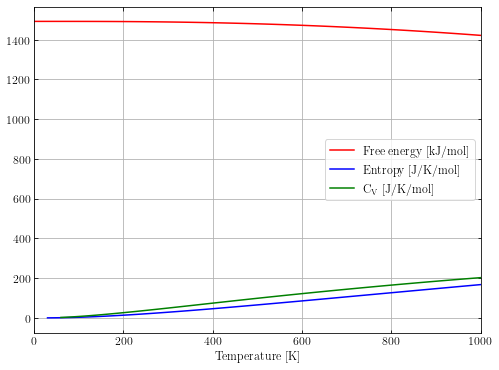

In [18]:
phonon.run_thermal_properties(t_step=10,t_max=1000,t_min=0)
tp_dict = phonon.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

phonon.plot_thermal_properties().show()